## IBSI Chapter 2 Phase 1 − Image filtering

### Technical validation of image filters without additional image processing

@Author : [MEDomics consortium](https://github.com/medomics/)

@EMAIL : medomics.info@gmail.com

@REF : [IBSI 2](https://www.overleaf.com/read/hwhjswzkhwdh)

**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

**Acknowledgement**: Most of the code used for this phase was written by [Alexandre Ayotte](https://github.com/AleAyotte) and modified by the authors of this Notebook.

### Introduction

We recommend to take a look at the [MEDscan-tutorial notebook](https://colab.research.google.com/github/MahdiAll99/MEDimage/blob/dev/notebooks/tutorial/MEDscan-Tutorial.ipynb) and the [DataManager-tutorial](https://colab.research.google.com/github/MahdiAll99/MEDimage/blob/dev/notebooks/tutorial/DataManager-Tutorial.ipynb) before running the IBSI tests.

The aim of this chapter and this phase is benchmarking the filters using the phantom images is to arrive at a standard implementation. We apply filter to the phantoms to create a response maps with the same dimensions as the phantoms (64 × 64 × 64 voxels). Filters need to be applied using the settings provided in [IBSI 2 benchmarking 5.1 Table 5.1](https://www.overleaf.com/read/hwhjswzkhwdh). In this notebook we implemented 28 different settings/tests from ***1a1*** to ***7a2***.

### Dataset - Digital phantoms
The IBSI developed several 3D phantoms to test image filter implementations. All phantoms (but the orientation phantom) have the same dimension and consist of 64 × 64 × 64 isotropic voxels with 2.0 by 2.0 by 2.0 mm spacing. 8-bit voxel intensities in all phantoms fall in the range [0, 255]. The phantoms are stored in the NIfTI format. The digital phantoms can be found here: [ibsi_2_digital_phantoms](https://github.com/theibsi/data_sets/tree/master/ibsi_2_digital_phantom).

The phantoms are shown in the figure below:

<img src="images/ibsi2-p1-phantoms.png" alt="Flowchart of radiomics study" style="width:500px;"/>

Every phantom has a goal to test a specific implementation. More details can be found in the [IBSI 2 section 5.1](https://www.overleaf.com/read/hwhjswzkhwdh)

### Initialization

In this chapter and phase we will not need any class and we will use the *MEDimage* package modules directly, especially the module ``filter`` which offers methods for image filtering. We recommend you download the data from [here](https://github.com/theibsi/data_sets/tree/master/ibsi_2_digital_phantom/nifti) and organize your folder as follows:

<img src="images/ibsi2-p1-folder-structure.png"/>


In [1]:
import math
import os
import sys

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


import MEDimage
import numpy as np

PyCUDA is not installed. Please install it to use the textural filters.


### Configuration

Most important part of the code is to chose what test will be executed. The figure below shows the different tests possible: 

*1a1, 1a2, 1a3...*.

In [2]:
test_id = '1a1' # test ID. More details about tests can be found in the IBSI chapter 2 reference

<div>
    <img src="images/ibsi2-p1-testids1.png" width="500"/>  
</div>

<div>
    <img src="images/ibsi2-p1-testids2.png" width="500"/>  
</div>

<div>
    <img src="images/ibsi2-p1-testids3.png" width="500"/>  
</div>

<div>
    <img src="images/ibsi2-p1-testids4.png" width="500"/>  
</div>

Refer to the [IBSI 2 section 5.1](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970) for more details.

In [3]:
def get_input(image_name, repertory="data/Filters"):
    """
    Import the nii image and cast it into numpy nd-array.
    :param image_name: The image name without the extension.
    :param repertory: The image repertory (Options: Data. Result_Alex)
    :return: a numpy nd-array of shape (B, W, H, D) with value between 0 and 1.
    """

    example_filename = os.path.join(
        repertory, image_name + '.nii'
    )
    try:
        input_data = nib.load(example_filename)
    except:
        input_data = nib.load(example_filename+'.gz')

    input_data.set_data_dtype(np.float64)

    return np.array(input_data.dataobj).astype(np.float64)

In [4]:
def plot_comparison(result, _slice, test_id, filter_name):
    """
    Plot the coronal, axial and sagittal slices of the ground truth, the result and their squared error
    :param result: The result obtained by the program.
    :param ground_truth: The result obtained by Alexandre Ayotte
    :param _slice: Which slice will be plotted along each axis.
    """

    fig = plt.figure(figsize=(12, 12))
    fig.canvas.manager.set_window_title('Phase1_ID' + test_id)
    
    vmin = np.min(result)
    vmax = np.max(result)

    fig.suptitle(f'Filter used : {filter_name}.\nResult\'s min : {vmin} Result\'s max : {vmax}',
                fontsize=16)

    fig.add_subplot(1, 3, 1, ylabel="Result")
    plt.imshow(result[:, :, _slice])

    fig.add_subplot(1, 3, 2)
    plt.imshow(result[:, _slice, :])

    fig.add_subplot(1, 3, 3)
    plt.imshow(result[_slice, :, :])
    
    # color settings
    norm = Normalize(vmin=vmin, vmax=vmax)
    colorbar = ScalarMappable(norm=norm)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(colorbar, cax=cbar_ax)

    plt.show()

### Initialization

As mentioned in the dataset section, all phantoms have the same voxel spacing of 2 so it's gonna be our voxel length and will be used to compute the kernel size for some filter.

In [5]:
VOLEX_LENGTH = 2

### Image processing

The only processing done in this phase is image filtering.

#### Image filtering

The filtering is done in three steps :
- Get the digital phantom from the dataset folder using the digital phantom name (Ex: checkerboard, response...) and convert the data type to float64 (or at least float32)
- Create an instance of the filter class
- Run the convolution using the instance.

The parameters are already defined for each test (check figures above) and if the *test_id* does not match any of the cases below an error will be raised.

Check cells above to set the *test_id* and to view all the test IDs and their configuration.

In [6]:
if test_id == "1a1":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_mean(
                        input_images=input_images,
                        ndims=3,
                        size=15, 
                        padding="constant")
    filter_name = "Mean"

elif test_id == "1a2":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_mean(
                        input_images=input_images,
                        ndims=3,
                        size=15, 
                        padding="edge")
    filter_name = "Mean"

elif test_id == "1a3":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_mean(
                        input_images=input_images,
                        ndims=3,
                        size=15, 
                        padding="wrap")
    filter_name = "Mean"

elif test_id == "1a4":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_mean(
                        input_images=input_images,
                        ndims=3,
                        size=15, 
                        padding="symmetric")
    filter_name = "Mean"

elif test_id == "1b1":
    input_images = get_input("response")
    result = MEDimage.filters.apply_mean(
                        input_images=input_images,
                        ndims=2,
                        size=15, 
                        padding="constant")
    filter_name = "Mean"

elif test_id == "2a":
    input_images = get_input("response")
    result = MEDimage.filters.apply_log(
                        input_images=input_images,
                        ndims=3,
                        voxel_length=VOLEX_LENGTH,
                        sigma=3,
                        padding="constant")
    filter_name = "LaplacianOfGaussian"

elif test_id == "2b":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_log(
                        input_images=input_images,
                        ndims=3,
                        voxel_length=VOLEX_LENGTH,
                        sigma=5,
                        padding="symmetric")
    filter_name = "LaplacianOfGaussian"

elif test_id == "2c":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_log(
                        input_images=input_images,
                        ndims=2,
                        voxel_length=VOLEX_LENGTH,
                        sigma=5,
                        padding="symmetric")
    filter_name = "LaplacianOfGaussian"

elif test_id == "3a1":
    input_images = get_input("response")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["E5", "L5", "S5"],
                        padding="constant")
    filter_name = "Laws"

elif test_id == "3a2":
    input_images = get_input("response")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["E5", "L5", "S5"],
                        padding="constant",
                        rot_invariance=True)
    filter_name = "Laws"

elif test_id == "3a3":
    input_images = get_input("response")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["E5", "L5", "S5"],
                        padding="constant",
                        rot_invariance=True,
                        energy_image=True)
    filter_name = "Laws"

elif test_id == "3b1":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["E3", "W5", "R5"],
                        padding="symmetric",
                        rot_invariance=False,
                        energy_image=False)
    filter_name = "Laws"

elif test_id == "3b2":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["E3", "W5", "R5"],
                        padding="symmetric",
                        rot_invariance=True,
                        energy_image=False)
    filter_name = "Laws"

elif test_id == "3b3":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["E3", "W5", "R5"],
                        padding="symmetric",
                        rot_invariance=True,
                        energy_image=True)
    filter_name = "Laws"

elif test_id == "3c1":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["L5", "S5"],
                        padding="symmetric",
                        rot_invariance=False,
                        energy_image=False)
    filter_name = "Laws"

elif test_id == "3c2":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["L5", "S5"],
                        padding="symmetric",
                        rot_invariance=True,
                        energy_image=False)
    filter_name = "Laws"
    
elif test_id == "3c3":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_laws(
                        input_images=input_images,
                        config=["L5", "S5"],
                        padding="symmetric",
                        rot_invariance=True,
                        energy_image=True)
    filter_name = "Laws"

elif test_id == "4a1":
    input_images = get_input("response")
    result = MEDimage.filters.apply_gabor(
                        input_images=input_images,
                        voxel_length=VOLEX_LENGTH,
                        sigma=10,
                        _lambda=4,
                        gamma=0.5,
                        theta=-math.pi/3,
                        padding="constant",
                        rot_invariance=False,
                        orthogonal_rot=False)
    filter_name = "Gabor"

elif test_id == "4a2":
    input_images = get_input("response")
    result = MEDimage.filters.apply_gabor(
                        input_images=input_images,
                        voxel_length=VOLEX_LENGTH,
                        sigma=10,
                        _lambda=4,
                        gamma=0.5,
                        theta=-math.pi/4,
                        padding="constant",
                        rot_invariance=True,
                        orthogonal_rot=True)
    filter_name = "Gabor"

elif test_id == "4b1":
    input_images = get_input("sphere")
    result = MEDimage.filters.apply_gabor(
                        input_images=input_images,
                        voxel_length=VOLEX_LENGTH,
                        sigma=20,
                        _lambda=8,
                        gamma=2.5,
                        theta=-5*math.pi/4,
                        padding="symmetric",
                        rot_invariance=False,
                        orthogonal_rot=False)
    filter_name = "Gabor"


elif test_id == "4b2":
    input_images = get_input("sphere")
    result = MEDimage.filters.apply_gabor(
                        input_images=input_images,
                        voxel_length=VOLEX_LENGTH,
                        sigma=20,
                        _lambda=8,
                        gamma=2.5,
                        theta=-math.pi/8,
                        padding="symmetric",
                        rot_invariance=True,
                        orthogonal_rot=True)
    filter_name = "Gabor"

elif test_id == "5a1":
    input_images = get_input("response")
    result = MEDimage.filters.apply_wavelet(
                        input_images=input_images,
                        ndims=3,
                        wavelet_name="db2",
                        subband="LHL",
                        level=1,
                        padding="constant",
                        rot_invariance=False)
    filter_name = "Wavelet_LHL_db2"

elif test_id == "5a2":
    input_images = get_input("response")
    result = MEDimage.filters.apply_wavelet(
                        input_images=input_images,
                        ndims=3,
                        wavelet_name="db2",
                        subband="LHL",
                        level=1,
                        padding="constant",
                        rot_invariance=True)
    filter_name = "Wavelet_LHL_db2"

elif test_id == "6a1":
    input_images = get_input("sphere")
    result = MEDimage.filters.apply_wavelet(
                        input_images=input_images,
                        ndims=3,
                        wavelet_name="coif1",
                        subband="HHL",
                        level=1,
                        padding="wrap",
                        rot_invariance=False)
    filter_name = "Wavelet_HHL_coif1"

elif test_id == "6a2":
    input_images = get_input("sphere")
    result = MEDimage.filters.apply_wavelet(
                        input_images=input_images,
                        ndims=3,
                        wavelet_name="coif1",
                        subband="HHL",
                        level=1,
                        padding="wrap",
                        rot_invariance=True)
    filter_name = "Wavelet_coif1"

elif test_id == "7a1":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_wavelet(
                        input_images=input_images,
                        ndims=3,
                        wavelet_name="haar",
                        subband="LLL",
                        level=2,
                        padding="symmetric",
                        rot_invariance=True)
    filter_name = "Wavelet_LLL_haar"

elif test_id == "7a2":
    input_images = get_input("checkerboard")
    result = MEDimage.filters.apply_wavelet(
                        input_images=input_images,
                        ndims=3,
                        wavelet_name="haar",
                        subband="HHH",
                        level=2,
                        padding="symmetric",
                        rot_invariance=True)
    filter_name = "Wavelet_HHH_haar"
else:
    raise NotImplementedError


Finally we print the results max and min for comparison and we plot the final results with the ground truth (if there is one).

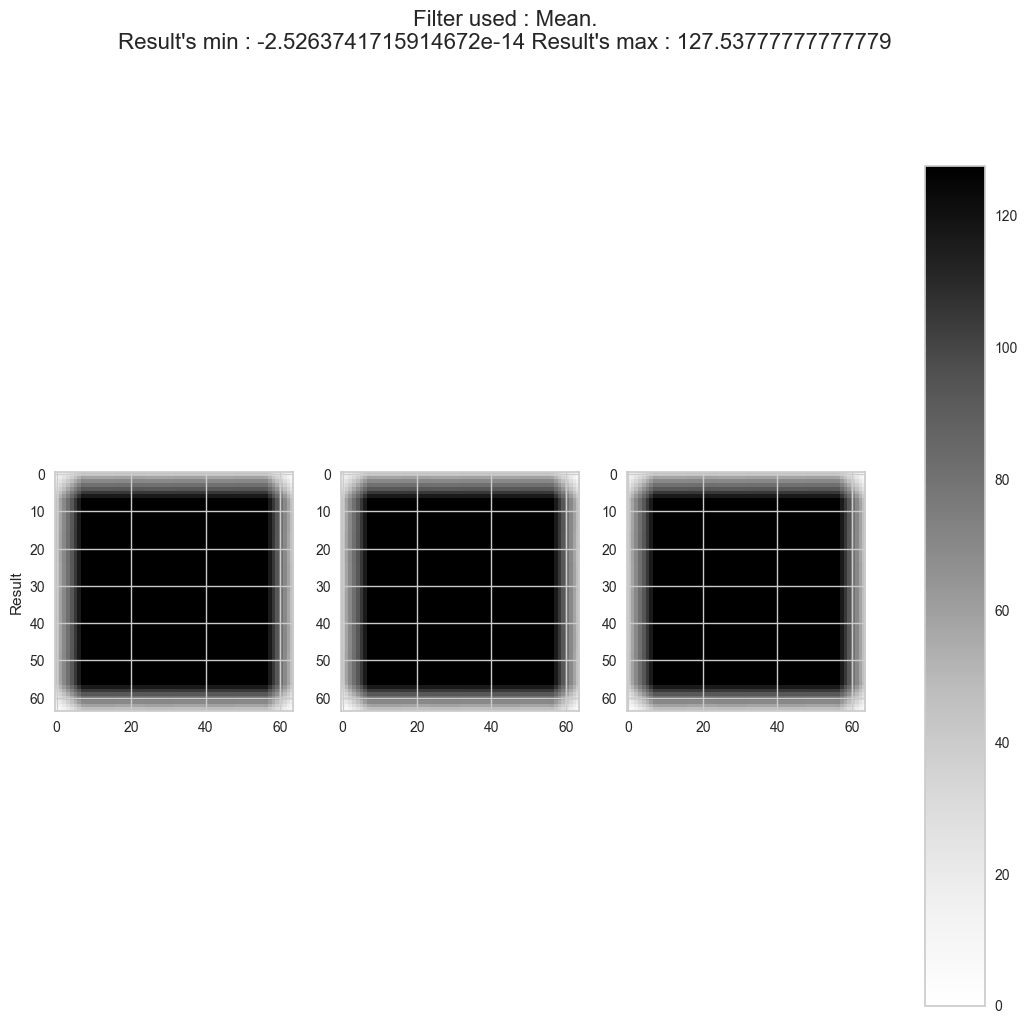

In [7]:
plot_comparison(result, 
                _slice=31, 
                test_id=test_id, 
                filter_name=filter_name)

You can compare your response maps with other IBSI teams on this [link](https://ibsi.radiomics.hevs.ch/viewer/2022-08-25)